Импортируем библиотеки

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import catboost as cb
from datetime import datetime
import seaborn as sns

In [2]:
data_train = pd.read_csv("./data/train.csv")
data_test = pd.read_csv("./data/test.csv")
data_webstat = pd.read_csv("./data/t1_webstat.csv")

is_callcenter - был ли совершен звонок в коллцентр по итогам сессии (нужно предсказать)

order_id - id заказа

create_time - время создания заказа

good_id - id товара

price - цена товара

utm_medium - тип трафика

utm_source - источник трафика

sessionkey_id - id сессии пользователя

category_id - id категории товара

parent_id - id родительской категории для категории товара

root_id - id "базовой" категории товара

rating_value - рейтинг товара

rating_count - число оценок товара

description_length - длина описания товара

goods_qty - число товаров в заказе

model_id - ???

is_moderated - ???

pics_qty - ???

model_create_time - ???

sessionkey_id - id сессии пользователя

date_time - timestamp захода на страницу определенного типа

page_type - тип просмотренной страницы

pageview_number - порядковый номер страницы среди всех страниц, отсортированных по времени посещения внутри сессии

pageview_duration_sec - время просмотра страницы

product_in_sale - ???

In [3]:
data_train["create_time_ts"] = None
data_test["create_time_ts"] = None
data_train["model_create_time_ts"] = None
data_test["model_create_time_ts"] = None

from datetime import datetime
# convert string to date
data_train.create_time_ts = data_train.apply(lambda x: datetime.strptime(x.create_time[:19], '%Y-%m-%d %H:%M:%S'), axis=1)
data_test.create_time_ts = data_test.apply(lambda x: datetime.strptime(x.create_time[:19], '%Y-%m-%d %H:%M:%S'), axis=1)

data_train.loc[~data_train.model_create_time.isna(), "model_create_time_ts"] = data_train.loc[~data_train.model_create_time.isna()].apply(lambda x: datetime.strptime(x.model_create_time[:19], '%Y-%m-%d %H:%M:%S'), axis=1)
data_test.loc[~data_test.model_create_time.isna(), "model_create_time_ts"] = data_test.loc[~data_test.model_create_time.isna()].apply(lambda x: datetime.strptime(x.model_create_time[:19], '%Y-%m-%d %H:%M:%S'), axis=1)

In [4]:
del data_train["create_time"]
del data_train["model_create_time"]
del data_test["create_time"]
del data_test["model_create_time"]

In [5]:
data_train.model_create_time_ts = data_train.model_create_time_ts.fillna(data_train.create_time_ts)
data_test.model_create_time_ts = data_test.model_create_time_ts.fillna(data_test.create_time_ts)

In [123]:
print("Рейтинг товаров, по которым позвонили: ", data_train[data_train["is_callcenter"] == 1]["rating_value"].mean(), 
      ", по которым не звонили", data_train[data_train["is_callcenter"] == 0]["rating_value"].mean())

Рейтинг товаров, по которым позвонили:  1.5399876007439555 , по которым не звонили 1.4771690174232548


In [124]:
print("Длина описания товаров, по которым позвонили: ", data_train[data_train["is_callcenter"] == 1]["description_length"].mean(), 
      ", по которым не звонили", data_train[data_train["is_callcenter"] == 0]["description_length"].mean())

Длина описания товаров, по которым позвонили:  572.92983638373 , по которым не звонили 573.338671921299


In [125]:
print("Представителей 0 класса: 67496, 1 класса: 37099")

Представителей 0 класса: 67496, 1 класса: 37099


In [15]:
A = data_train.groupby(['root_id'])['is_callcenter'].sum().sort_values()
B = data_train.groupby(['root_id'])['is_callcenter'].count().sort_values()
C = A.divide(B).sort_values()

order_id = list(data_train["order_id"].unique())
new_column = list()
for order in order_id:
    root = list(data_train[data_train["order_id"] == order]["root_id"].values)[0]
    new_column.append(C[root])
new_column_test = list()
for order in list(data_test["order_id"].unique()):
    root = list(data_test[data_test["order_id"] == order]["root_id"].values)[0]
    new_column_test.append(C[root])
data_train['root_mean_call'] = new_column
data_test['root_mean_call'] = new_column_test

In [666]:
new_column = list()
for order in range(data_train.shape[0]):
    hour = data_train["create_time_ts"][order].time().hour * 60 + data_train["create_time_ts"][order].time().minute
    new_column.append(hour)
data_train['hour'] = new_column
new_column = list()
for order in range(data_test.shape[0]):
    hour = data_train["create_time_ts"][order].time().hour * 60 + data_train["create_time_ts"][order].time().minute
    new_column.append(hour)
data_test['hour'] = new_column

In [54]:
data_train["utm_source"].fillna(0, inplace=True)
data_test["utm_source"].fillna(0, inplace=True)

In [66]:
data_train["rating_value"].fillna(0, inplace=True)
data_test["rating_value"].fillna(0, inplace=True)

In [75]:
data_train["rating_count"].fillna(0, inplace=True)
data_test["rating_count"].fillna(0, inplace=True)

In [149]:
new_column = list()
for order in range(data_train.shape[0]):
    day = data_train["create_time_ts"][order].date().weekday()
    new_column.append(day)
data_train['day_of_week'] = new_column
new_column = list()
for order in range(data_test.shape[0]):
    day = data_test["create_time_ts"][order].date().weekday()
    new_column.append(day)
data_test['day_of_week'] = new_column

In [654]:
new_column = list()
for order in range(data_train.shape[0]):
    day = data_train["create_time_ts"][order].date().month
    new_column.append(day)
data_train['month'] = new_column
new_column = list()
for order in range(data_test.shape[0]):
    day = data_test["create_time_ts"][order].date().month
    new_column.append(day)
data_test['month'] = new_column

In [1199]:
new_column = list()
for order in range(data_train.shape[0]):
    day = data_train["create_time_ts"][order].date().day
    new_column.append(day)
data_train['day'] = new_column
new_column = list()
for order in range(data_test.shape[0]):
    day = data_test["create_time_ts"][order].date().day
    new_column.append(day)
data_test['day'] = new_column

In [164]:
data_train["life_time"] = (data_train.create_time_ts - data_train.model_create_time_ts).astype('timedelta64[D]')
data_test["life_time"] = (data_test.create_time_ts - data_test.model_create_time_ts).astype('timedelta64[D]')

In [203]:
new_column = list()
for num in range(data_train.shape[0]):
    sess_key = data_train["sessionkey_id"][num]
    max_time = data_webstat[data_webstat["sessionkey_id"] == sess_key]["pageview_duration_sec"].max()
    new_column.append(max_time)
data_train['max_time_in_page'] = new_column
new_column = list()
for num in range(data_test.shape[0]):
    sess_key = data_test["sessionkey_id"][num]
    max_time = data_webstat[data_webstat["sessionkey_id"] == sess_key]["pageview_duration_sec"].max()
    new_column.append(max_time)
data_test['max_time_in_page'] = new_column

In [ ]:
data_train["max_time_in_page"].fillna(-1, inplace=True)
data_test["max_time_in_page"].fillna(-1, inplace=True)

In [263]:
new_column = list()
for num in range(data_train.shape[0]):
    sess_key = data_train["sessionkey_id"][num]
    count_page = data_webstat[data_webstat["sessionkey_id"] == sess_key].shape[0]
    new_column.append(count_page)
data_train['count_page'] = new_column
new_column = list()
for num in range(data_test.shape[0]):
    sess_key = data_test["sessionkey_id"][num]
    count_page = data_webstat[data_webstat["sessionkey_id"] == sess_key].shape[0]
    new_column.append(count_page)
data_test['count_page'] = new_column

In [264]:
data_train["count_page"].fillna(0, inplace=True)
data_test["count_page"].fillna(0, inplace=True)

In [229]:
new_column = list()
for num in range(data_train.shape[0]):
    sess_key = data_train["sessionkey_id"][num]
    count_page = data_webstat[data_webstat["sessionkey_id"] == sess_key]["pageview_duration_sec"].sum()
    new_column.append(count_page)
data_train['sum_time_page'] = new_column
new_column = list()
for num in range(data_test.shape[0]):
    sess_key = data_test["sessionkey_id"][num]
    count_page = data_webstat[data_webstat["sessionkey_id"] == sess_key]["pageview_duration_sec"].sum()
    new_column.append(count_page)
data_test['sum_time_page'] = new_column

In [230]:
data_train["sum_time_page"].fillna(0, inplace=True)
data_test["sum_time_page"].fillna(0, inplace=True)

In [244]:
new_column = list()
for num in range(data_train.shape[0]):
    sess_key = data_train["sessionkey_id"][num]
    count_page = data_webstat[data_webstat["sessionkey_id"] == sess_key]["pageview_duration_sec"].mean()
    new_column.append(count_page)
data_train['mean_time_page'] = new_column
new_column = list()
for num in range(data_test.shape[0]):
    sess_key = data_test["sessionkey_id"][num]
    count_page = data_webstat[data_webstat["sessionkey_id"] == sess_key]["pageview_duration_sec"].mean()
    new_column.append(count_page)
data_test['mean_time_page'] = new_column

In [245]:
data_train["mean_time_page"].fillna(0, inplace=True)
data_test["mean_time_page"].fillna(0, inplace=True)

In [333]:
data_webstat["page_type"].unique()

array([ 2,  5,  1,  7,  3,  4,  6,  9,  8, 10, 12, 13, 11])

In [319]:
DATA = data_webstat[data_webstat["page_type"] == 1]
new_column = list()
for num in range(data_train.shape[0]):
    sess_key = data_train["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key].shape[0]
    new_column.append(count_page)
data_train['count_webpage_1'] = new_column
new_column = list()
for num in range(data_test.shape[0]):
    sess_key = data_test["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key].shape[0]
    new_column.append(count_page)
data_test['count_webpage_1'] = new_column

In [320]:
data_train["count_webpage_1"].fillna(0, inplace=True)
data_test["count_webpage_1"].fillna(0, inplace=True)

In [334]:
DATA = data_webstat[data_webstat["page_type"] == 2]
new_column = list()
for num in range(data_train.shape[0]):
    sess_key = data_train["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key].shape[0]
    new_column.append(count_page)
data_train['count_webpage_2'] = new_column
new_column = list()
for num in range(data_test.shape[0]):
    sess_key = data_test["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key].shape[0]
    new_column.append(count_page)
data_test['count_webpage_2'] = new_column

In [335]:
data_train["count_webpage_2"].fillna(0, inplace=True)
data_test["count_webpage_2"].fillna(0, inplace=True)

In [344]:
DATA = data_webstat[data_webstat["page_type"] == 3]
new_column = list()
for num in range(data_train.shape[0]):
    sess_key = data_train["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key].shape[0]
    new_column.append(count_page)
data_train['count_webpage_3'] = new_column
new_column = list()
for num in range(data_test.shape[0]):
    sess_key = data_test["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key].shape[0]
    new_column.append(count_page)
data_test['count_webpage_3'] = new_column

In [345]:
data_train["count_webpage_3"].fillna(0, inplace=True)
data_test["count_webpage_3"].fillna(0, inplace=True)

In [358]:
DATA = data_webstat[data_webstat["page_type"] == 4]
new_column = list()
for num in range(data_train.shape[0]):
    sess_key = data_train["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key].shape[0]
    new_column.append(count_page)
data_train['count_webpage_4'] = new_column
new_column = list()
for num in range(data_test.shape[0]):
    sess_key = data_test["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key].shape[0]
    new_column.append(count_page)
data_test['count_webpage_4'] = new_column

In [359]:
data_train["count_webpage_4"].fillna(0, inplace=True)
data_test["count_webpage_4"].fillna(0, inplace=True)

In [368]:
DATA = data_webstat[data_webstat["page_type"] == 5]
new_column = list()
for num in range(data_train.shape[0]):
    sess_key = data_train["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key].shape[0]
    new_column.append(count_page)
data_train['count_webpage_5'] = new_column
new_column = list()
for num in range(data_test.shape[0]):
    sess_key = data_test["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key].shape[0]
    new_column.append(count_page)
data_test['count_webpage_5'] = new_column

In [369]:
data_train["count_webpage_5"].fillna(0, inplace=True)
data_test["count_webpage_5"].fillna(0, inplace=True)

In [378]:
DATA = data_webstat[data_webstat["page_type"] == 13]
new_column = list()
for num in range(data_train.shape[0]):
    sess_key = data_train["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key].shape[0]
    new_column.append(count_page)
data_train['count_webpage_13'] = new_column
new_column = list()
for num in range(data_test.shape[0]):
    sess_key = data_test["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key].shape[0]
    new_column.append(count_page)
data_test['count_webpage_13'] = new_column

In [379]:
data_train["count_webpage_13"].fillna(0, inplace=True)
data_test["count_webpage_13"].fillna(0, inplace=True)

In [407]:
DATA = data_webstat[data_webstat["page_type"] == 6]
new_column = list()
for num in range(data_train.shape[0]):
    sess_key = data_train["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key].shape[0]
    new_column.append(count_page)
data_train['count_webpage_6'] = new_column
new_column = list()
for num in range(data_test.shape[0]):
    sess_key = data_test["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key].shape[0]
    new_column.append(count_page)
data_test['count_webpage_6'] = new_column

In [408]:
data_train["count_webpage_6"].fillna(0, inplace=True)
data_test["count_webpage_6"].fillna(0, inplace=True)

In [431]:
DATA = data_webstat[data_webstat["page_type"] == 7]
new_column = list()
for num in range(data_train.shape[0]):
    sess_key = data_train["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key].shape[0]
    new_column.append(count_page)
data_train['count_webpage_7'] = new_column
new_column = list()
for num in range(data_test.shape[0]):
    sess_key = data_test["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key].shape[0]
    new_column.append(count_page)
data_test['count_webpage_7'] = new_column
data_train["count_webpage_7"].fillna(0, inplace=True)
data_test["count_webpage_7"].fillna(0, inplace=True)

In [455]:
DATA = data_webstat[data_webstat["page_type"] == 8]
new_column = list()
for num in range(data_train.shape[0]):
    sess_key = data_train["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key].shape[0]
    new_column.append(count_page)
data_train['count_webpage_8'] = new_column
new_column = list()
for num in range(data_test.shape[0]):
    sess_key = data_test["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key].shape[0]
    new_column.append(count_page)
data_test['count_webpage_8'] = new_column
data_train["count_webpage_8"].fillna(0, inplace=True)
data_test["count_webpage_8"].fillna(0, inplace=True)

In [471]:
DATA = data_webstat[data_webstat["page_type"] == 9]
new_column = list()
for num in range(data_train.shape[0]):
    sess_key = data_train["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key].shape[0]
    new_column.append(count_page)
data_train['count_webpage_9'] = new_column
new_column = list()
for num in range(data_test.shape[0]):
    sess_key = data_test["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key].shape[0]
    new_column.append(count_page)
data_test['count_webpage_9'] = new_column
data_train["count_webpage_9"].fillna(0, inplace=True)
data_test["count_webpage_9"].fillna(0, inplace=True)

In [496]:
DATA = data_webstat[data_webstat["page_type"] == 10]
new_column = list()
for num in range(data_train.shape[0]):
    sess_key = data_train["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key].shape[0]
    new_column.append(count_page)
data_train['count_webpage_10'] = new_column
new_column = list()
for num in range(data_test.shape[0]):
    sess_key = data_test["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key].shape[0]
    new_column.append(count_page)
data_test['count_webpage_10'] = new_column
data_train["count_webpage_10"].fillna(0, inplace=True)
data_test["count_webpage_10"].fillna(0, inplace=True)

In [505]:
DATA = data_webstat[data_webstat["page_type"] == 11]
new_column = list()
for num in range(data_train.shape[0]):
    sess_key = data_train["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key].shape[0]
    new_column.append(count_page)
data_train['count_webpage_11'] = new_column
new_column = list()
for num in range(data_test.shape[0]):
    sess_key = data_test["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key].shape[0]
    new_column.append(count_page)
data_test['count_webpage_11'] = new_column
data_train["count_webpage_11"].fillna(0, inplace=True)
data_test["count_webpage_11"].fillna(0, inplace=True)

In [521]:
DATA = data_webstat[data_webstat["page_type"] == 12]
new_column = list()
for num in range(data_train.shape[0]):
    sess_key = data_train["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key].shape[0]
    new_column.append(count_page)
data_train['count_webpage_12'] = new_column
new_column = list()
for num in range(data_test.shape[0]):
    sess_key = data_test["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key].shape[0]
    new_column.append(count_page)
data_test['count_webpage_12'] = new_column
data_train["count_webpage_12"].fillna(0, inplace=True)
data_test["count_webpage_12"].fillna(0, inplace=True)

In [578]:
# new_column = list()
# for num in range(data_train.shape[0]):
#     sess_key = data_train["sessionkey_id"][num]
#     count_page = data_webstat[data_webstat["sessionkey_id"] == sess_key].sort_values(by = "pageview_number", ascending = False)["page_type"].iloc[0]
#     new_column.append(count_page)
# data_train['last_page'] = new_column
# new_column = list()
# for num in range(data_test.shape[0]):
#     sess_key = data_test["sessionkey_id"][num]
#     count_page = data_webstat[data_webstat["sessionkey_id"] == sess_key].sort_values(by = "pageview_number", ascending = False)["page_type"].iloc[0]
#     new_column.append(count_page)
# data_test['last_page'] = new_column
# data_train["last_page"].fillna(0, inplace=True)
# data_test["last_page"].fillna(0, inplace=True)

In [681]:
DATA = data_webstat[data_webstat["page_type"] == 1]
new_column = list()
for num in range(data_train.shape[0]):
    sess_key = data_train["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key]["pageview_duration_sec"].sum()
    new_column.append(count_page)
data_train['sum_min_1'] = new_column
new_column = list()
for num in range(data_test.shape[0]):
    sess_key = data_test["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key]["pageview_duration_sec"].sum()
    new_column.append(count_page)
data_test['sum_min_1'] = new_column
data_train["sum_min_1"].fillna(0, inplace=True)
data_test["sum_min_1"].fillna(0, inplace=True)

In [690]:
DATA = data_webstat[data_webstat["page_type"] == 2]
new_column = list()
for num in range(data_train.shape[0]):
    sess_key = data_train["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key]["pageview_duration_sec"].sum()
    new_column.append(count_page)
data_train['sum_min_2'] = new_column
new_column = list()
for num in range(data_test.shape[0]):
    sess_key = data_test["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key]["pageview_duration_sec"].sum()
    new_column.append(count_page)
data_test['sum_min_2'] = new_column
data_train["sum_min_2"].fillna(0, inplace=True)
data_test["sum_min_2"].fillna(0, inplace=True)

In [700]:
DATA = data_webstat[data_webstat["page_type"] == 3]
new_column = list()
for num in range(data_train.shape[0]):
    sess_key = data_train["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key]["pageview_duration_sec"].sum()
    new_column.append(count_page)
data_train['sum_min_3'] = new_column
new_column = list()
for num in range(data_test.shape[0]):
    sess_key = data_test["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key]["pageview_duration_sec"].sum()
    new_column.append(count_page)
data_test['sum_min_3'] = new_column
data_train["sum_min_3"].fillna(0, inplace=True)
data_test["sum_min_3"].fillna(0, inplace=True)

In [724]:
DATA = data_webstat[data_webstat["page_type"] == 4]
new_column = list()
for num in range(data_train.shape[0]):
    sess_key = data_train["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key]["pageview_duration_sec"].sum()
    new_column.append(count_page)
data_train['sum_min_4'] = new_column
new_column = list()
for num in range(data_test.shape[0]):
    sess_key = data_test["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key]["pageview_duration_sec"].sum()
    new_column.append(count_page)
data_test['sum_min_4'] = new_column
data_train["sum_min_4"].fillna(0, inplace=True)
data_test["sum_min_4"].fillna(0, inplace=True)

In [733]:
DATA = data_webstat[data_webstat["page_type"] == 5]
new_column = list()
for num in range(data_train.shape[0]):
    sess_key = data_train["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key]["pageview_duration_sec"].sum()
    new_column.append(count_page)
data_train['sum_min_5'] = new_column
new_column = list()
for num in range(data_test.shape[0]):
    sess_key = data_test["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key]["pageview_duration_sec"].sum()
    new_column.append(count_page)
data_test['sum_min_5'] = new_column
data_train["sum_min_5"].fillna(0, inplace=True)
data_test["sum_min_5"].fillna(0, inplace=True)

In [742]:
DATA = data_webstat[data_webstat["page_type"] == 6]
new_column = list()
for num in range(data_train.shape[0]):
    sess_key = data_train["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key]["pageview_duration_sec"].sum()
    new_column.append(count_page)
data_train['sum_min_6'] = new_column
new_column = list()
for num in range(data_test.shape[0]):
    sess_key = data_test["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key]["pageview_duration_sec"].sum()
    new_column.append(count_page)
data_test['sum_min_6'] = new_column
data_train["sum_min_6"].fillna(0, inplace=True)
data_test["sum_min_6"].fillna(0, inplace=True)

DATA = data_webstat[data_webstat["page_type"] == 7]
new_column = list()
for num in range(data_train.shape[0]):
    sess_key = data_train["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key]["pageview_duration_sec"].sum()
    new_column.append(count_page)
data_train['sum_min_7'] = new_column
new_column = list()
for num in range(data_test.shape[0]):
    sess_key = data_test["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key]["pageview_duration_sec"].sum()
    new_column.append(count_page)
data_test['sum_min_7'] = new_column
data_train["sum_min_7"].fillna(0, inplace=True)
data_test["sum_min_7"].fillna(0, inplace=True)

In [1287]:
DATA = data_webstat[data_webstat["page_type"] == 8]
new_column = list()
for num in range(data_train.shape[0]):
    sess_key = data_train["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key]["pageview_duration_sec"].sum()
    new_column.append(count_page)
data_train['sum_min_8'] = new_column
new_column = list()
for num in range(data_test.shape[0]):
    sess_key = data_test["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key]["pageview_duration_sec"].sum()
    new_column.append(count_page)
data_test['sum_min_8'] = new_column
data_train["sum_min_8"].fillna(0, inplace=True)
data_test["sum_min_8"].fillna(0, inplace=True)

DATA = data_webstat[data_webstat["page_type"] == 9]
new_column = list()
for num in range(data_train.shape[0]):
    sess_key = data_train["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key]["pageview_duration_sec"].sum()
    new_column.append(count_page)
data_train['sum_min_9'] = new_column
new_column = list()
for num in range(data_test.shape[0]):
    sess_key = data_test["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key]["pageview_duration_sec"].sum()
    new_column.append(count_page)
data_test['sum_min_9'] = new_column
data_train["sum_min_9"].fillna(0, inplace=True)
data_test["sum_min_9"].fillna(0, inplace=True)

In [952]:
new_column = list()
for num in range(data_train.shape[0]):
    sess_key = data_train["sessionkey_id"][num]
    count_second = (data_train[data_train["sessionkey_id"] == sess_key]["create_time_ts"].max() - data_webstat[data_webstat["sessionkey_id"] == sess_key]['time'].max()).seconds
    new_column.append(count_second)
data_train['second_order_last'] = new_column
new_column = list()
for num in range(data_test.shape[0]):
    sess_key = data_test["sessionkey_id"][num]
    count_second = (data_test[data_test["sessionkey_id"] == sess_key]["create_time_ts"].max() - data_webstat[data_webstat["sessionkey_id"] == sess_key]['time'].max()).seconds
    new_column.append(count_second)
data_test['second_order_last'] = new_column

In [1061]:
new_column = list()
for num in range(data_train.shape[0]):
    sess_key = data_train["sessionkey_id"][num]
    count_second = (data_webstat[data_webstat["sessionkey_id"] == sess_key]['time'].max() - data_webstat[data_webstat["sessionkey_id"] == sess_key]['time'].min()).seconds
    new_column.append(count_second)
data_train['first_last_time'] = new_column
new_column = list()
for num in range(data_test.shape[0]):
    sess_key = data_test["sessionkey_id"][num]
    count_second = (data_webstat[data_webstat["sessionkey_id"] == sess_key]['time'].max() - data_webstat[data_webstat["sessionkey_id"] == sess_key]['time'].min()).seconds
    new_column.append(count_second)
data_test['first_last_time'] = new_column

In [1806]:
new_column = list()
for num in range(data_train.shape[0]):
    sess_key = data_train["sessionkey_id"][num]
    max_time = list(data_train[data_train["sessionkey_id"] == sess_key]["first_last_time"])[0] - list(data_train[data_train["sessionkey_id"] == sess_key]["sum_time_page"])[0]
    new_column.append(max_time)
data_train['non_session_time'] = new_column
new_column = list()
for num in range(data_test.shape[0]):
    sess_key = data_test["sessionkey_id"][num]
    max_time = list(data_test[data_test["sessionkey_id"] == sess_key]["first_last_time"])[0] - list(data_test[data_test["sessionkey_id"] == sess_key]["sum_time_page"])[0]
    new_column.append(max_time)
data_test['non_session_time'] = new_column

In [1807]:
data_train

,order_id,good_id,price,utm_medium,utm_source,sessionkey_id,category_id,parent_id,root_id,model_id,...,sum_min_4,sum_min_5,sum_min_6,sum_min_7,second_order_last,first_last_time,day,sum_min_8,sum_min_9,non_session_time
0,1269921,9896348,753,5,8.0,123777004,139,133,124,123517,...,0.0,0.0,0.0,0.0,545.0,0.0,26,0.0,0.0,0.0
1,1270034,9896348,753,1,2.0,123781654,139,133,124,123517,...,0.0,15.0,0.0,0.0,86272.0,4237.0,26,33.0,0.0,406.0
2,1268272,9896348,753,2,3.0,123591002,139,133,124,123517,...,0.0,15.0,0.0,0.0,76.0,370.0,25,72.0,0.0,0.0
3,1270544,9896348,753,1,1.0,123832302,139,133,124,123517,...,0.0,0.0,0.0,0.0,85569.0,1926.0,26,0.0,0.0,0.0
4,1270970,9896348,753,3,56.0,123881603,139,133,124,123517,...,0.0,0.0,47.0,0.0,233.0,447.0,26,0.0,0.0,353.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104590,1250981,68657110,1497,4,1.0,121795335,2873,1229,1183,35231362,...,1614.0,0.0,0.0,0.0,83726.0,3124.0,16,0.0,0.0,15.0
104591,1173775,60391507,1354,1,2.0,114277105,2873,1229,1183,35231362,...,0.0,0.0,0.0,0.0,41690.0,1046.0,8,34.0,0.0,436.0
104592,1180920,66971400,1452,2,0.0,114972131,2873,1229,1183,35231362,...,0.0,0.0,39.0,0.0,86349.0,2276.0,12,0.0,0.0,674.0
104593,1177882,60391498,1433,4,2.0,114672813,2873,1229,1183,35231362,...,0.0,19.0,0.0,0.0,305.0,1361.0,10,0.0,0.0,0.0


In [1714]:
# features = [  
#             "model_id",  
#             "category_id", 
#             "utm_medium", 
#             "price", 
#             "hour",
#             "utm_source",
#             "day_of_week",
#             "max_time_in_page",
#             "count_page",
#             "sum_time_page",
#             "mean_time_page",
#             "count_webpage_1",
#             "count_webpage_3",
#             "count_webpage_6",
#             "sum_min_3",
#             "second_order_last",
#             "first_last_time", 
#            ] - 0.8673

In [1732]:
data_train.columns

Index(['order_id', 'good_id', 'price', 'utm_medium', 'utm_source',
       'sessionkey_id', 'category_id', 'parent_id', 'root_id', 'model_id',
       'is_moderated', 'rating_value', 'rating_count', 'description_length',
       'goods_qty', 'pics_qty', 'is_callcenter', 'create_time_ts',
       'model_create_time_ts', 'root_mean_call', 'hour', 'day_of_week',
       'life_time', 'max_time_in_page', 'count_page', 'sum_time_page',
       'mean_time_page', 'count_webpage_1', 'count_webpage_2',
       'count_webpage_3', 'count_webpage_4', 'count_webpage_5',
       'count_webpage_13', 'count_webpage_6', 'count_webpage_7',
       'count_webpage_8', 'count_webpage_9', 'count_webpage_10',
       'count_webpage_11', 'count_webpage_12', 'month', 'sum_min_1',
       'sum_min_2', 'sum_min_3', 'sum_min_4', 'sum_min_5', 'sum_min_6',
       'sum_min_7', 'second_order_last', 'first_last_time', 'day', 'sum_min_8',
       'sum_min_9'],
      dtype='object')

In [1808]:
features = ['good_id', 
            'price', 
            'utm_medium', 
            'utm_source',
            'sessionkey_id', 
            'category_id', 
            'parent_id',   
            'description_length',
            'create_time_ts',
            'hour',
            'day_of_week',
            'max_time_in_page',
            'count_page',
            'sum_time_page',
            'mean_time_page',
            'count_webpage_1',
            'count_webpage_2',
            'count_webpage_3',
            'count_webpage_6',
            'sum_min_1',
            'sum_min_2',
            'sum_min_3',
            'sum_min_6',
            'second_order_last',
            'first_last_time',
            'day',
            "non_session_time"
]

# ОБУЧЕНИЕ (TEST)

In [1809]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from catboost import cv
from catboost import Pool

In [1810]:
X_train_val, X_test, y_train_val, y_test = train_test_split(data_train[features], data_train["is_callcenter"], test_size=0.15, stratify=data_train["is_callcenter"])
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15, stratify = y_train_val)

In [1811]:
model = CatBoostClassifier(eval_metric = 'AUC', class_weights = [0.35, 0.65], verbose = 100)

In [1812]:
model.fit(X_train, y_train,eval_set=(X_val, y_val), use_best_model=True)

Learning rate set to 0.092227
0:	test: 0.9356848	best: 0.9356848 (0)	total: 13.9ms	remaining: 13.9s
100:	test: 0.9566700	best: 0.9566787 (98)	total: 1.2s	remaining: 10.7s
200:	test: 0.9582498	best: 0.9582676 (198)	total: 2.29s	remaining: 9.12s
300:	test: 0.9588410	best: 0.9588851 (296)	total: 3.36s	remaining: 7.8s
400:	test: 0.9592344	best: 0.9592701 (395)	total: 4.43s	remaining: 6.62s
500:	test: 0.9593848	best: 0.9593848 (500)	total: 5.52s	remaining: 5.5s
600:	test: 0.9594441	best: 0.9594441 (600)	total: 6.61s	remaining: 4.39s
700:	test: 0.9595852	best: 0.9595858 (699)	total: 7.67s	remaining: 3.27s
800:	test: 0.9595866	best: 0.9596050 (789)	total: 8.74s	remaining: 2.17s
900:	test: 0.9595956	best: 0.9596394 (881)	total: 9.97s	remaining: 1.09s
999:	test: 0.9598277	best: 0.9598277 (999)	total: 11.2s	remaining: 0us

bestTest = 0.9598277469
bestIteration = 999



In [1813]:
predictions = model.predict(X_test[features])

In [1814]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, predictions)

0.8821376992446175

In [1815]:
model.get_feature_importance()

array([ 1.76955448,  2.28957102,  1.57779168,  1.58842017,  1.5653973 ,
        1.72887076,  1.62610983,  1.13610303,  1.27623191,  5.18256467,
        4.01126516,  2.85240293,  0.89053985,  1.78257561,  3.5979061 ,
        0.96355757,  1.01210571,  3.08966617,  5.51983318,  1.55276091,
        1.20145454,  5.34417613,  1.54650973, 27.74585192,  1.69175546,
        0.96486981, 16.49215438])

[12 15 25 16  7 20  8 22 19  4  2  3  6 24  5  0 13  1 11 17 14 10  9 21
 18 26 23]


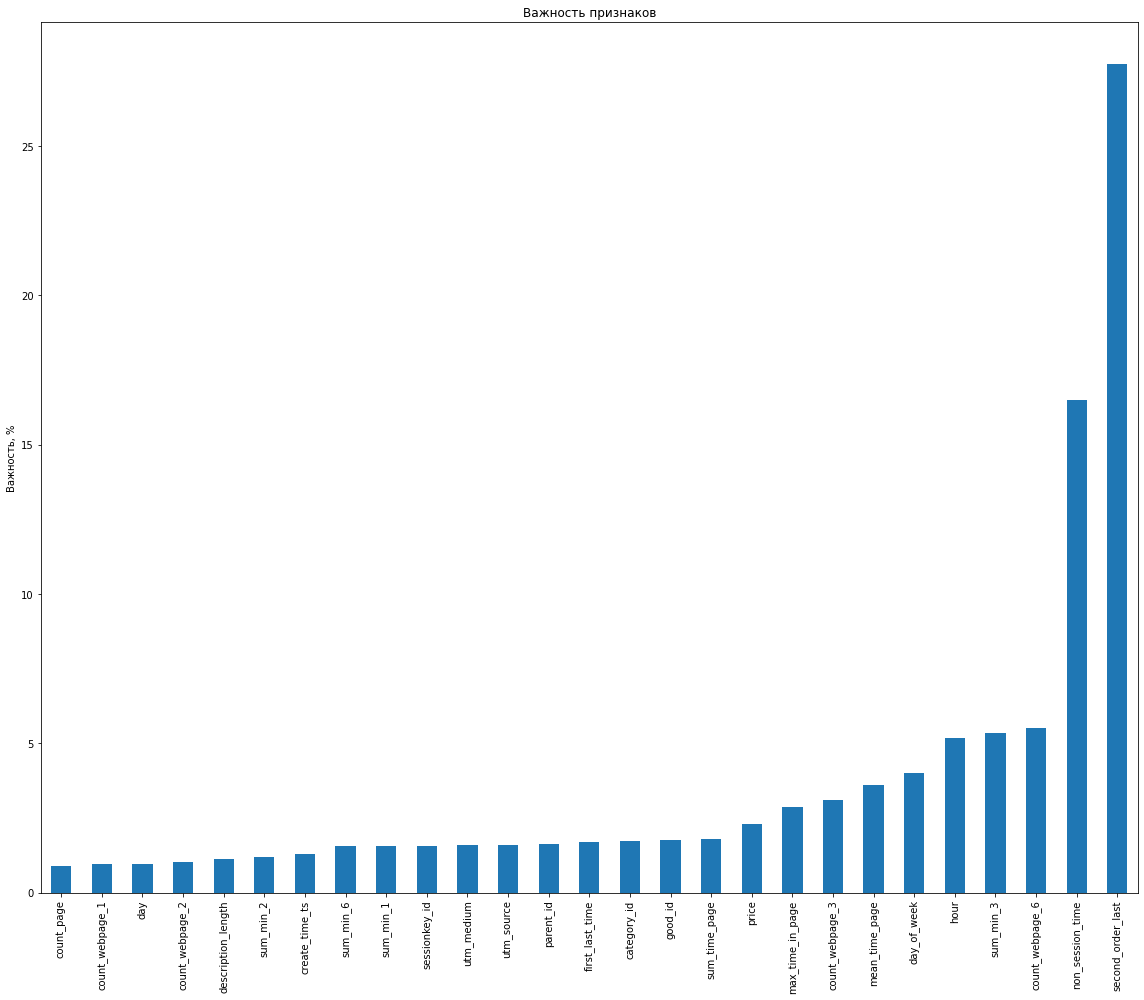

In [1816]:
indices = model.get_feature_importance().argsort()
print(indices)
cat_iris_imp = pd.Series(np.array(model.get_feature_importance())[indices],
                         np.array(features)[indices])
fig, ax = plt.subplots(figsize=(16,14))
cat_iris_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность, %')
fig.tight_layout()

# ОБУЧЕНИЕ (Kaggle)

In [1817]:
X_train, X_val, y_train, y_val = train_test_split(data_train[features], data_train["is_callcenter"], test_size=0.2, random_state=42, stratify=data_train["is_callcenter"])

In [1819]:
model = CatBoostClassifier(eval_metric = 'AUC', class_weights = [0.35, 0.65], verbose = 100, iterations=1000)
model.fit(X_train, y_train,eval_set=(X_val, y_val), use_best_model=True)

Learning rate set to 0.094578
0:	test: 0.9346319	best: 0.9346319 (0)	total: 17.1ms	remaining: 17.1s
100:	test: 0.9565807	best: 0.9565807 (100)	total: 1.29s	remaining: 11.5s
200:	test: 0.9584631	best: 0.9584631 (200)	total: 2.49s	remaining: 9.92s
300:	test: 0.9591961	best: 0.9591961 (300)	total: 3.98s	remaining: 9.23s
400:	test: 0.9595929	best: 0.9596062 (398)	total: 5.19s	remaining: 7.75s
500:	test: 0.9598401	best: 0.9598673 (498)	total: 6.39s	remaining: 6.36s
600:	test: 0.9601013	best: 0.9601035 (581)	total: 7.56s	remaining: 5.02s
700:	test: 0.9601863	best: 0.9601863 (700)	total: 8.73s	remaining: 3.72s
800:	test: 0.9601282	best: 0.9602315 (716)	total: 9.94s	remaining: 2.47s
900:	test: 0.9603291	best: 0.9603363 (899)	total: 11.2s	remaining: 1.23s
999:	test: 0.9603946	best: 0.9604138 (987)	total: 12.6s	remaining: 0us

bestTest = 0.9604138092
bestIteration = 987

Shrink model to first 988 iterations.


In [1820]:
predictions = model.predict(data_test[features])

In [1821]:
id_column = data_test["order_id"]
result_column = predictions
dataset = pd.DataFrame({'order_id': id_column, 'is_callcenter': list(result_column)}, columns=['order_id', 'is_callcenter'])
dataset.to_csv("sample_submission.csv", index=False)

In [1256]:
data_train.to_csv("data_train_new.csv", index=False)

In [1257]:
data_test.to_csv("data_test_new.csv", index=False)